# Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# Define Data File Paths

In [2]:
import os
import numpy as np
import pandas as pd

def load_dataset_from_directory(base_dir):
    """
    Load all experiments from all SOH folders in the base directory.

    Returns:
        X: shape (total_experiments, time_length, 2) -- [U, I]
        y: shape (total_experiments, time_length, 2) -- [SOC, SOH]
    """
    all_X = []
    all_y = []

    for folder_name in os.listdir(base_dir):
        folder_path = os.path.join(base_dir, folder_name)
        if not os.path.isdir(folder_path):
            continue

        # Extract SOH from folder name, e.g., "90% SOH" -> 0.90
        try:
            soh_value = float(folder_name.split('%')[0]) / 100.0
        except ValueError:
            print(f"Skipping folder with unexpected name format: {folder_name}")
            continue

        # Load CSVs
        u_data = pd.read_csv(os.path.join(folder_path, 'U.csv'), header=None).values
        i_data = pd.read_csv(os.path.join(folder_path, 'I.csv'), header=None).values
        soc_data = pd.read_csv(os.path.join(folder_path, 'SOC.csv'), header=None).values

        # Shape: (num_experiments, time_length)
        assert u_data.shape == i_data.shape == soc_data.shape

        # Stack U and I to create features: (num_experiments, time_length, 2)
        X = np.stack((u_data, i_data), axis=-1)

        # Create a constant SOH matrix: same shape as SOC
        soh_matrix = np.full_like(soc_data, soh_value)

        # Stack SOC and SOH as output: (num_experiments, time_length, 2)
        y = np.stack((soc_data, soh_matrix), axis=-1)

        all_X.append(X)
        all_y.append(y)

    # Concatenate all experiments from all folders
    X_all = np.concatenate(all_X, axis=0)
    y_all = np.concatenate(all_y, axis=0)
    return X_all, y_all


# -------------------------------
base_dir = '/content/drive/My Drive/CS282/Final Project/DATA/'
X, y = load_dataset_from_directory(base_dir)


In [90]:
from sklearn.model_selection import train_test_split

# Split into train/val/test (80/10/10)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=666)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=666)

In [63]:
# Global normalization (per feature, across all samples and time)
# Step 1: Compute mean and std from training set: fit
# Step 2: Normalize all datasets using training stats: transform

class Normalizer:
    def __init__(self):
        self.mean = None
        self.std = None
        self.epsilon = 1e-8

    def fit(self, data: np.ndarray):
        """
        Compute mean and std from training data (NumPy array).

        Args:
            data (np.ndarray): Training data of shape (N, T, D)
        """
        self.mean = np.mean(data, axis=(0, 1), keepdims=True)
        self.std = np.std(data, axis=(0, 1), keepdims=True) + self.epsilon

    def transform(self, data: np.ndarray) -> np.ndarray:
        """
        Normalize data using training-set statistics.
        """
        return (data - self.mean) / self.std

    def fit_transform(self, data: np.ndarray) -> np.ndarray:
        """
        Fit statistics and return normalized data.
        """
        self.fit(data)
        return self.transform(data)

    def save(self, path: str):
        """
        Save mean and std to disk.
        """
        np.savez(path, mean=self.mean, std=self.std)

    def load(self, path: str):
        """
        Load mean and std from disk.
        """
        stats = np.load(path)
        self.mean = stats['mean']
        self.std = stats['std']


In [108]:
# Global normalization (per feature, across all samples and time)
normalizer = Normalizer()

X_train = normalizer.fit_transform(X_train)

X_val = normalizer.transform(X_val)
X_test = normalizer.transform(X_test)

In [109]:
### check the Train-Test Distribution Shift
print(X_val.std(axis=(0, 1), keepdims=True),
      X_val.mean(axis=(0, 1), keepdims=True),
      X_test.std(axis=(0, 1), keepdims=True),
      X_test.mean(axis=(0, 1), keepdims=True),
      )

[[[1.01128914 1.00715682]]] [[[0.00893431 0.00460876]]] [[[1.00469031 1.0037669 ]]] [[[-0.01573031 -0.00320233]]]


# Transformer model for SOC Estimation

In [110]:
import torch.nn as nn
import torch.nn.functional as F
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import os

In [121]:
def set_seed(seed= 666):
    np.random.seed(seed)                    # NumPy RNG
    torch.manual_seed(seed)                 # PyTorch CPU RNG
    torch.cuda.manual_seed(seed)            # PyTorch GPU RNG
    torch.cuda.manual_seed_all(seed)        # All GPUs (if using multi-GPU)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False  # Ensures reproducibility, but may slow down training

set_seed(666)


In [131]:
# ----- CONFIGURATION -----
SEQ_LEN = 300
INPUT_DIM = 2  # V(t), I(t)

MODEL_DIM = 256
NUM_HEADS = 2
FF_DIM = 1024
NUM_LAYERS = 2 # Number of stacked Transformer encoder blocks
DROPOUT = 0.1

BATCH_SIZE = 128
EPOCHS = 50
LR = 5e-5
CHECKPOINT_PATH = "soc_transformer.pt"

In [132]:
# ----- DEVICE SETUP -----
!nvidia-smi
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Mon May  5 05:54:23 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   40C    P0             51W /  400W |    4117MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [133]:
# ----- POS ENCODING -----
class SinusoidPositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.0, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        # div_term = torch.exp(torch.arange(0, d_model, 2) * (-np.log(10000.0) / d_model))
        div_term = 1/torch.pow(10000, torch.arange(0, d_model, 2) / d_model)
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Arguments:
            x: Tensor, shape ``[seq_len, batch_size, embedding_dim]``
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)



In [134]:
# ----- MODEL DEFINITION -----
class SOCTransformer(nn.Module):
    def __init__(self, input_dim, model_dim, seq_len, num_heads, num_layers, dropout=0.1):
        super().__init__()
        self.seq_len = seq_len
        self.embed_size = model_dim

        # Step 1: Project raw inputs (voltage, current) to model_dim
        self.input_proj = nn.Linear(input_dim, model_dim)

        # Step 2: Generate positional encoding to provide order information
        self.pos_encoding = SinusoidPositionalEncoding(d_model=model_dim, dropout=0, max_len=seq_len)

        # Step 3: Generate Causal mask, Define transformer encoder with multi-head self-attention
        '''
        in pytorch TransformerEncoderLayer for a binary mask, a True value indicates that the corresponding key value will be ignored for the purpose of attention.
        ref: https://sanjayasubedi.com.np/deeplearning/masking-in-attention/
        '''
        self.causal_mask = torch.triu(torch.full((seq_len, seq_len), float('-inf')), diagonal=1) # (T, T)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=model_dim,
            nhead=num_heads,
            dim_feedforward= FF_DIM,
            dropout=dropout,
            batch_first=True  # ensures (B, T, D) input shape
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Step 4: feedforward MLP block for Regression  — one SOC value per timestep
        self.mlp = nn.Sequential(
            nn.Linear(model_dim, model_dim * 8),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Linear(model_dim * 8, model_dim),
            nn.ReLU(),

            nn.Linear(model_dim, 2)
        )

    def forward(self, x):

        # Input shape to SOCTransformer.forward is (B: batch size, T: sequence length, D: number of features (voltage and current))

        # Project input to embedding space
        x = self.input_proj(x)

        # Add positional encoding
        x = self.pos_encoding(x)

        # Pass through transformer layers with causal mask
        x = self.encoder(
            x, mask=self.causal_mask.to(x.device)
        )

        # Pass through MLP layers and Predict SOC at each timestep
        return self.mlp(x).squeeze(-1)

# ----- SSL LOSS -----
def ssl_pretrain_loss(x, x_hat, mask):
    return F.mse_loss(x_hat[mask], x[mask])

# ----- SUPERVISED LOSS -----
def log_cosh_loss(y_pred, y_true):
    return torch.mean(torch.log(torch.cosh(y_pred - y_true)))

def mse_loss(y_pred, y_true):
    return torch.sqrt(F.mse_loss(y_pred, y_true))

loss_fn = mse_loss


def compute_rmse_mae(y_pred, y_true):
    rmse = torch.sqrt(F.mse_loss(y_pred, y_true)).item()
    mae = F.l1_loss(y_pred, y_true).item()
    return rmse, mae

# ----- DATASET -----
class BatteryDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


In [135]:
# ----- TRAINING LOOP -----

def train_model(model, train_loader, val_loader, device):
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    best_val_loss = float('inf')

    # Store loss values for plotting
    train_losses = []
    val_losses = []

    for epoch in range(EPOCHS):
        model.train()
        total_loss = 0
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            optimizer.zero_grad()
            y_pred = model(batch_x)
            loss = loss_fn(y_pred, batch_y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                y_pred = model(batch_x)
                val_loss += loss_fn(y_pred, batch_y).item()
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        if avg_val_loss < best_val_loss:
            torch.save(model.state_dict(), CHECKPOINT_PATH)
            best_val_loss = avg_val_loss

        print(f"Epoch {epoch+1}/{EPOCHS}, Train Loss: {avg_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Best Val Loss: {best_val_loss:.4f}")


    # Plot losses
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss over Epochs')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [136]:
def evaluate_and_plot(model, test_loader, device):
    model.load_state_dict(torch.load(CHECKPOINT_PATH))
    model.eval()
    all_preds, all_trues, all_inputs = [], [], []

    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            y_pred = model(batch_x)
            all_preds.append(y_pred.cpu())
            all_trues.append(batch_y.cpu())
            all_inputs.append(batch_x.cpu())

    y_pred = torch.cat(all_preds, dim=0) * 100  # Scale to %
    y_true = torch.cat(all_trues, dim=0) * 100
    x_data = torch.cat(all_inputs, dim=0)  # shape: (N, T, 2)

    # Split SOC and SOH
    soc_pred, soh_pred = y_pred[:, :, 0], y_pred[:, :, 1]
    soc_true, soh_true = y_true[:, :, 0], y_true[:, :, 1]

    # Compute metrics
    soc_rmse, soc_mae = compute_rmse_mae(soc_pred, soc_true)
    soh_rmse, soh_mae = compute_rmse_mae(soh_pred, soh_true)

    print(f"Test SOC RMSE (%): {soc_rmse:.4f}, MAE (%): {soc_mae:.4f}")
    print(f"Test SOH RMSE (%): {soh_rmse:.4f}, MAE (%): {soh_mae:.4f}")

    # Plot a few sequences
    for i in range(3):
        fig, ax = plt.subplots(3, 1, figsize=(10, 9), gridspec_kw={'height_ratios': [2, 2, 2]})

        time = range(x_data.size(1))
        u = x_data[i, :, 0].numpy()
        i_ = x_data[i, :, 1].numpy()

        # --- Subplot 1: Input ---
        ax_u = ax[0]
        ax_i = ax_u.twinx()
        ax_u.plot(time, u, 'b-', label='U(t)')
        ax_i.plot(time, i_, 'r--', label='I(t)')
        ax_u.set_ylabel("U (V)", color='b')
        ax_i.set_ylabel("I (A)", color='r')
        ax_u.set_xlabel("Timestep")
        ax_u.set_title(f"Example {i+1} - U and I Input")
        lines, labels = ax_u.get_legend_handles_labels()
        lines2, labels2 = ax_i.get_legend_handles_labels()
        ax_u.legend(lines + lines2, labels + labels2, loc='upper right')

        # --- Subplot 2: SOC Prediction ---
        ax[1].plot(soc_true[i].numpy(), label='True SoC')
        ax[1].plot(soc_pred[i].numpy(), label='Pred SoC')
        ax[1].set_ylabel("SOC (%)")
        ax[1].set_title(f"Example {i+1} - SOC Prediction")
        ax[1].legend()
        ax[1].set_ylim(min(soc_true[i].min(), soc_pred[i].min()) - 5,
                       max(soc_true[i].max(), soc_pred[i].max()) + 5)

        # --- Subplot 3: SOH Prediction ---
        ax[2].plot(soh_true[i].numpy(), label='True SOH')
        ax[2].plot(soh_pred[i].numpy(), label='Pred SOH')
        ax[2].set_ylabel("SOH (%)")
        ax[2].set_title(f"Example {i+1} - SOH Prediction")
        ax[2].legend()
        ax[2].set_ylim(min(soh_true[i].min(), soh_pred[i].min()) - 5,
                       max(soh_true[i].max(), soh_pred[i].max()) + 5)

        plt.tight_layout()
        plt.show()


In [137]:
model = SOCTransformer(INPUT_DIM, MODEL_DIM, SEQ_LEN, NUM_HEADS, NUM_LAYERS).to(device)

train_dataset = BatteryDataset(X_train, y_train)
val_dataset = BatteryDataset(X_val, y_val)
test_dataset = BatteryDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

Epoch 1/50, Train Loss: 0.0739, Val Loss: 0.0582, Best Val Loss: 0.0582
Epoch 2/50, Train Loss: 0.0600, Val Loss: 0.0584, Best Val Loss: 0.0582
Epoch 3/50, Train Loss: 0.0575, Val Loss: 0.0544, Best Val Loss: 0.0544
Epoch 4/50, Train Loss: 0.0551, Val Loss: 0.0517, Best Val Loss: 0.0517
Epoch 5/50, Train Loss: 0.0520, Val Loss: 0.0487, Best Val Loss: 0.0487
Epoch 6/50, Train Loss: 0.0486, Val Loss: 0.0457, Best Val Loss: 0.0457
Epoch 7/50, Train Loss: 0.0464, Val Loss: 0.0442, Best Val Loss: 0.0442
Epoch 8/50, Train Loss: 0.0453, Val Loss: 0.0425, Best Val Loss: 0.0425
Epoch 9/50, Train Loss: 0.0445, Val Loss: 0.0431, Best Val Loss: 0.0425
Epoch 10/50, Train Loss: 0.0435, Val Loss: 0.0415, Best Val Loss: 0.0415
Epoch 11/50, Train Loss: 0.0428, Val Loss: 0.0414, Best Val Loss: 0.0414
Epoch 12/50, Train Loss: 0.0420, Val Loss: 0.0403, Best Val Loss: 0.0403
Epoch 13/50, Train Loss: 0.0415, Val Loss: 0.0397, Best Val Loss: 0.0397
Epoch 14/50, Train Loss: 0.0408, Val Loss: 0.0379, Best Val 

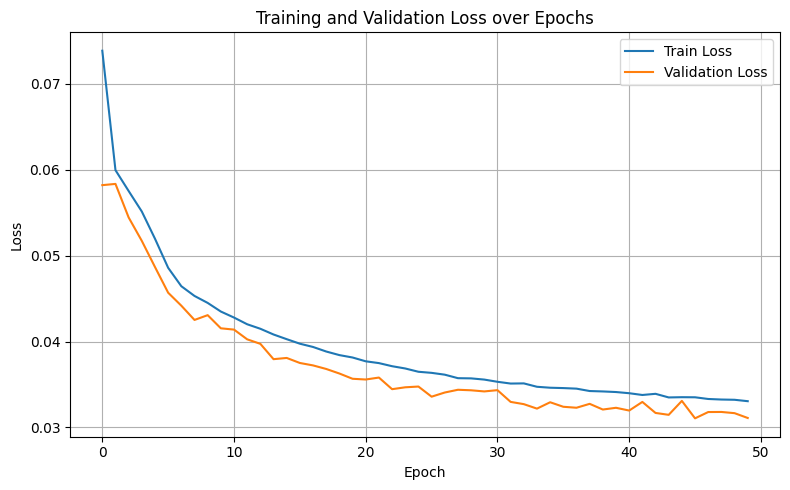

In [138]:
train_model(model, train_loader, val_loader, device)

Test SOC RMSE (%): 2.6931, MAE (%): 1.6314
Test SOH RMSE (%): 3.3271, MAE (%): 2.2214


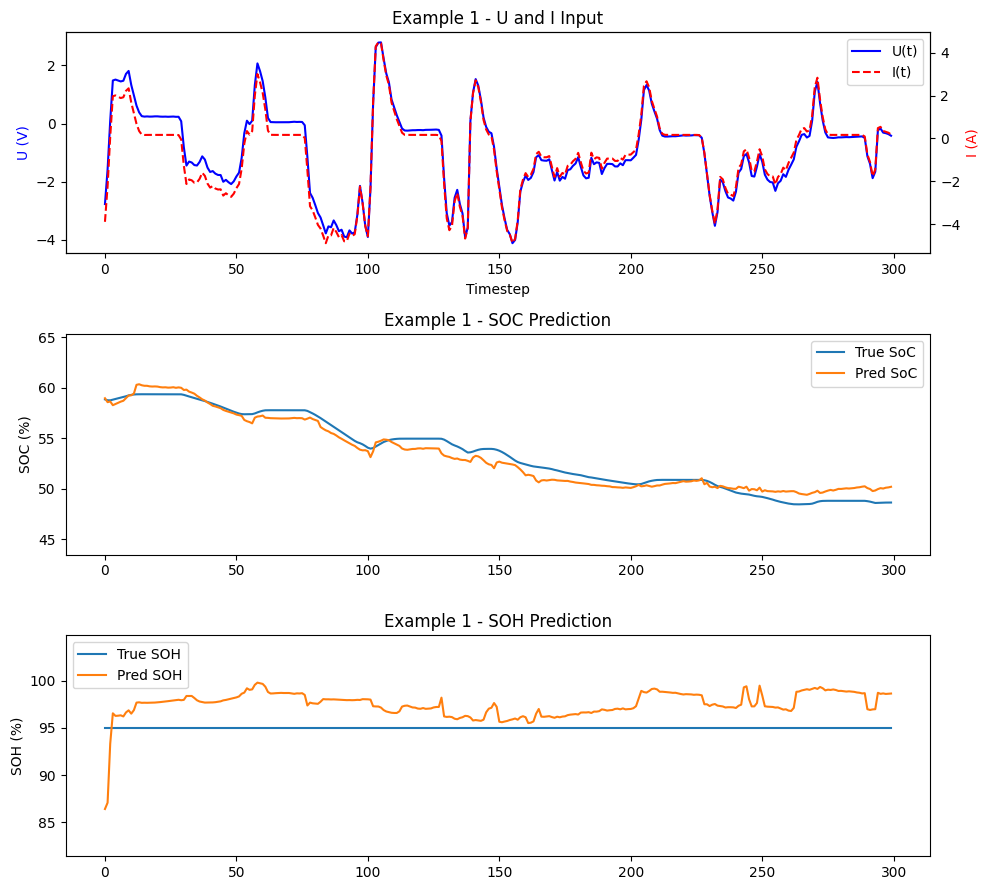

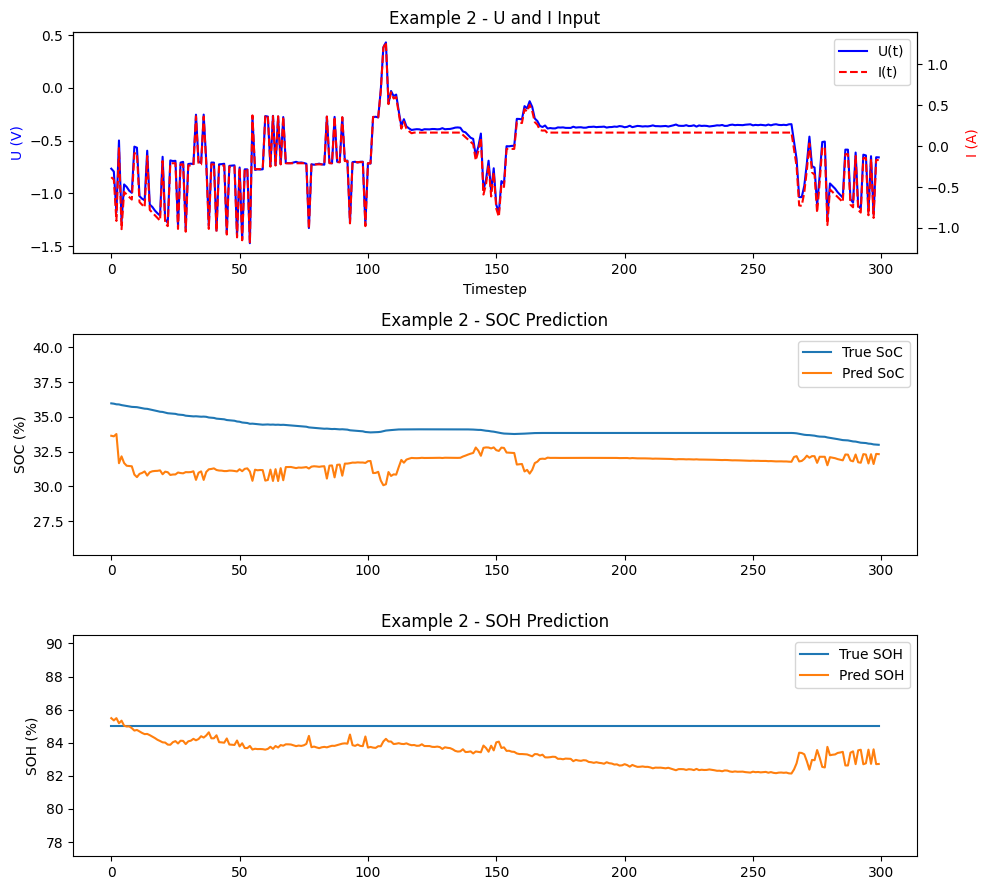

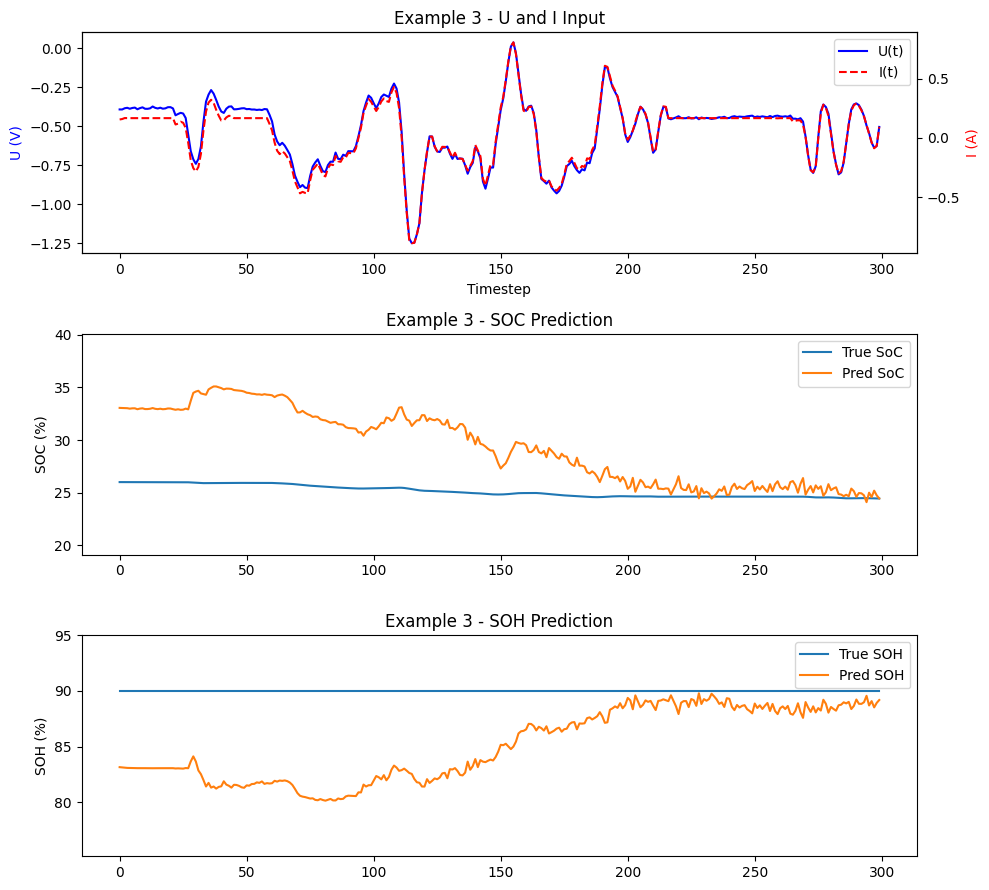

In [139]:
evaluate_and_plot(model, test_loader, device)


In [148]:
import time

def test_infer_time(model, test_loader, device):
    model.load_state_dict(torch.load(CHECKPOINT_PATH))
    model.eval()

    total_infer_time = 0.0
    total_samples = 0

    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            start_time = time.time()
            y_pred = model(batch_x)
            end_time = time.time()

            total_infer_time += (end_time - start_time)
            total_samples += batch_x.size(0)

    print(f"Number of Samples: {total_samples}")

    avg_infer_time = total_infer_time / total_samples
    print(f"Average Inference Time per Sample: {avg_infer_time * 1e6:.1f} µs")

test_infer_time(model, test_loader, device)

Number of Samples: 6843
Average Inference Time per Sample: 18.2 µs
